In [60]:
import sys,os,os.path
sys.path.append(os.path.expanduser('~/Codes/SolutionDistillation'))
import numpy as np
import tensorflow as tf
import os
from distill.common.hparams import TransformerHparam, LSTMHparam
from distill.data_util.prep_algorithmic import AlgorithmicIdentityDecimal40, AlgorithmicAdditionDecimal40, \
  AlgorithmicMultiplicationDecimal40, AlgorithmicSortProblem, AlgorithmicReverseProblem, AlgorithmicIdentityBinary40
from distill.data_util.prep_arithmatic import Arithmatic
from distill.data_util.prep_imdb import IMDB
from distill.data_util.prep_ptb import PTB
from distill.data_util.prep_sst import SST
from distill.data_util.prep_wsj_parsing import ParseWSJ
from distill.models.lstm_seq2seq import LSTMSeq2Seq, BidiLSTMSeq2Seq
from distill.models.transformer import Transformer, UniversalTransformer, EncodingTransformer, \
  EncodingUniversalTransformer
from distill.pipelines.seq2seq import Seq2SeqTrainer

# Enable TF Eager execution
tfe = tf.contrib.eager
tfe.enable_eager_execution()

# Other setup
Modes = tf.estimator.ModeKeys

In [20]:

task = Arithmatic('data/arithmatic')

transformer_params = TransformerHparam(input_dim=task.vocab_length,
                                         hidden_dim=300,
                                         output_dim=len(task.target_vocab),
                                         encoder_depth=1,
                                         decoder_depth=1,
                                         number_of_heads=2,
                                         ff_filter_size=512,
                                         initializer_gain=0.1,
                                         batch_size=32,
                                         input_dropout_keep_prob=0.0,
                                         hidden_dropout_keep_prob=0.0,
                                         vocab_size=task.vocab_length,
                                         label_smoothing=0.1,
                                         encoder_self_attention_dir="top_down",
                                         decoder_self_attention_dir="top_down",
                                         decoder_cross_attention_dir="top_down",
                                         train_embeddings=False,
                                         learning_rate=0.001
                                         )
trainer = Seq2SeqTrainer(transformer_params, None, task)



['<pad>', '<eos>', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155',

In [48]:
train_dataset = tf.data.TFRecordDataset("../"+task.get_tfrecord_path(mode="train"))
train_dataset = train_dataset.map(task.parse_examples)
train_dataset = train_dataset.padded_batch(1000, padded_shapes=task.get_padded_shapes())
train_dataset = train_dataset.shuffle(buffer_size=1000)
train_dataset = train_dataset.repeat()

train_examples = tfe.Iterator(train_dataset).next()



dev_dataset = tf.data.TFRecordDataset("../"+task.get_tfrecord_path(mode="dev"))
dev_dataset = dev_dataset.map(task.parse_examples)
dev_dataset = dev_dataset.padded_batch(1000, padded_shapes=task.get_padded_shapes())
dev_dataset = dev_dataset.shuffle(buffer_size=1000)
dev_dataset = dev_dataset.repeat()

dev_examples = tfe.Iterator(dev_dataset).next()




test_dataset = tf.data.TFRecordDataset("../"+task.get_tfrecord_path(mode="test"))
test_dataset = test_dataset.map(task.parse_examples)
test_dataset = test_dataset.padded_batch(1000, padded_shapes=task.get_padded_shapes())
test_dataset = test_dataset.shuffle(buffer_size=1000)
test_dataset = test_dataset.repeat()

test_examples = tfe.Iterator(test_dataset).next()


In [49]:
def get_stats_from_examples(batched_examples):
    lengthes = []
    targets = []
    for example_inputs, example_targets in zip(batched_examples[0], batched_examples[1]):
        np_example_inputs = example_inputs.numpy()
        np_example_targets = example_targets.numpy()[0]
        if 0 in list(np_example_inputs):
            length = list(np_example_inputs).index(0)
        else:
            length = len(np_example_inputs)
        lengthes.append(length)
        targets.append(np_example_targets)
    return lengthes, targets

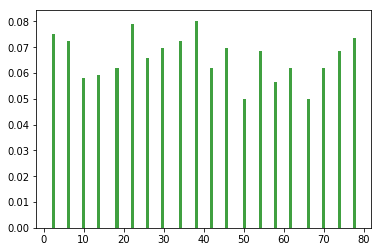

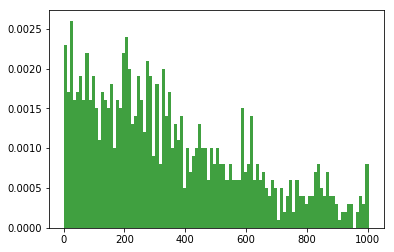

In [50]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline  


lengthes, targets = get_stats_from_examples(train_examples)

n, bins, patches = plt.hist(lengthes, 100, density=True, facecolor='g', alpha=0.75)
plt.show()

n, bins, patches = plt.hist(targets, 100, density=True, facecolor='g', alpha=0.75)
plt.show()

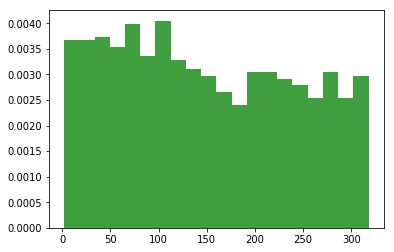

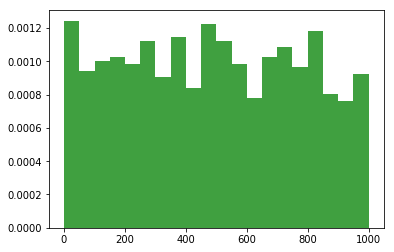

In [51]:


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline  


lengthes, targets = get_stats_from_examples(dev_examples)

n, bins, patches = plt.hist(lengthes, 20, density=True, facecolor='g', alpha=0.75)
plt.show()

n, bins, patches = plt.hist(targets, 20, density=True, facecolor='g', alpha=0.75)
plt.show()

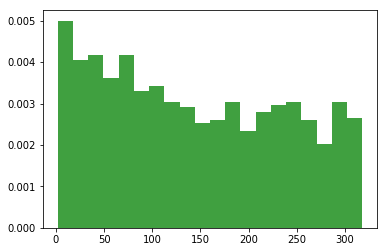

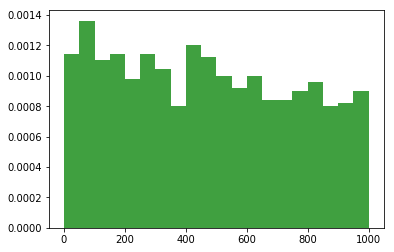

In [52]:


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline  


lengthes, targets = get_stats_from_examples(test_examples)

n, bins, patches = plt.hist(lengthes, 20, density=True, facecolor='g', alpha=0.75)
plt.show()

n, bins, patches = plt.hist(targets, 20, density=True, facecolor='g', alpha=0.75)
plt.show()

In [79]:
print(task.decode(task.encode(str("1 + 1").split())))
i = np.random.randint(len(train_examples))
print(i)
i = 100
example_inputs, example_targets = list(zip(train_examples[0], train_examples[1]))[i]
print(' '.join(task.decode(example_inputs)).replace('<pad>',''))


['1', '+', '1']
0
( ( ( 80 + 75 ) + ( 33 + 44 ) ) + ( 15 + ( ( ( ( 30 - 4 ) + ( 76 - 20 ) ) - ( 51 + 26 ) ) + ( ( 28 + 27 ) + 77 ) ) ) ) <eos>                        
